# Numerical calculation of the SCI diffraction phase

Numerical phase calculations can be integrated into the phase calculation in a relatively straightforward way. These calculations might be somewhat limited and less efficient compared to what code designed for a particular interferometer geometry could achieve--if you want to study a specific interferometer configuration in depth, you probably want to write a dedicated function from scratch. However this approach is good for exploring the performance of different interferometers.

In this example we will replicate Fig. 3b from the paper [High-Resolution Atom Interferometers with Suppressed Diffraction Phases](http://dx.doi.org/10.1103/PhysRevLett.115.083002).

First we will define the code that links the numerical calculation code to the `interferometer` module.

In [ ]:
from mwave.symbolic import Interferometer, InterferometerNode, Beamsplitter, FreeEv, set_constants, eval_sympy_var
from mwave.integrate import gbragg, make_kvec, make_phi
import sympy as sp

# Define a numeric unitary operator for single frequency Bragg
class SingleFreqBragg(Beamsplitter):
    
    def gen_numeric(self, node, subs={}):
        delta = eval_sympy_var(self.delta, subs)
        n_init = eval_sympy_var(node.parent.n, subs)
        n_final = eval_sympy_var(node.n, subs)
        kvec, n0_idx, nf_idx = make_kvec(n_init, n_final)
        def fnc(omega, sigma, v, ratio):
            sol = gbragg(kvec, make_phi(kvec, n_init), 2*2.716*sigma, delta + 2*v, -2*np.pi*omega, sigma)
            return sol.y[nf_idx,-1]
        return fnc

# Define a numeric unitary operator for multi frequency Bragg
class MultiFreqBragg(Beamsplitter):

    def __init__(self, n1, n2, delta, k, omega_m):
        super().__init__(n1, n2, delta + omega_m, k)
        self.delta_numeric = delta
        self.omega_m = omega_m
    
    def gen_numeric(self, node, subs={}):
        delta = float(eval_sympy_var(self.delta_numeric, subs))
        omega_m = float(eval_sympy_var(self.omega_m, subs))
        n_init = eval_sympy_var(node.parent.n, subs)
        n_final = eval_sympy_var(node.n, subs)
        kvec, n0_idx, nf_idx = make_kvec(n_init, n_final)
        def fnc(omega, sigma, v, ratio):
            sol = gbragg(kvec, make_phi(kvec, n_init), 2*2.716*sigma, delta + 2*v, -2*np.pi*omega*ratio/4, sigma, omega_mod=omega_m)
            return sol.y[nf_idx,-1]
        return fnc

Here we have defined two classes, each of which inherit from the `Beamsplitter` class. The first, `SingleFreqBragg`, will act exactly as the `Beamsplitter` class does, although it implements the function `gen_numeric`, which we need to override to implement numerical phase calculations.

The second, `MultiFreqBragg`, modifies the behavior of the `Beamsplitter` class slightly as it sets the value of `delta` passed to the super `__init__` function to `delta+omega_m`. This ensures that the analytically calculated phase uses the correct detuning. It then saves the `delta` passed into its own `__init__` function as `delta_numeric`, which is used inside the `gen_numeric` function.

Both `SingleFreqBragg` and `MultiFreqBragg` return a function titled `fnc`. When called `fnc` computes the wavefunction obtained after applying a Bragg pulse. To do this it uses the `gbragg` function from the `integrate` module. The function calls in `SingleFreqBragg` and `MultiFreqBragg` are very similar--the main difference is that the multifrequency one modifies the intensity by `ratio` and passes in `omega_mod` to compute a multifrequency pulse. This makes it consistent with Holger's code used to generate Fig.3b in the paper referenced above.

Next we set up our interferometer as usual by defining our constants, our unitary operators, and writing down the sequence of unitary operators needed to generate the SCI. Finally we determine which nodes are interfering.

In [2]:
# Set up symbols for symbolic computation
k, c, hbar, m, n, T, Tp, delta, omega_m, omega_r, t_traj, g, v0, Toffset = sp.symbols('k c hbar m n T T_p delta omega_m omega_r t_traj g v_0 T_offset', real=True)
k_eff = 2*k
set_constants(m=m,hbar=hbar,c=c,t_traj=t_traj)

# Define the operators needed for an SCI
bs1 = SingleFreqBragg(n, 0, delta, k_eff)
bs2 = MultiFreqBragg(0, -n, delta, k_eff, -omega_m)
bs2u = MultiFreqBragg(n, 2*n, delta, k_eff, +omega_m)
fe1 = FreeEv(T)
fe2 = FreeEv(Tp)

# Define the interferometer
ii = Interferometer(init_node=InterferometerNode(n=n, v=2*hbar*k*n/m))
ii.apply(bs1)
ii.apply(fe1)
ii.apply(bs1)
ii.apply(fe2)
ii.apply(bs2)
ii.apply(bs2u)
ii.apply(fe1)
ii.apply(bs2)
ii.apply(bs2u)

# Determine the intefering nodes
inodes = ii.interfere()

Lets check that we get the expected SCI phase.

In [3]:
phi_A, phi_B, phi_C, phi_D = ii.phases()
print(sp.expand(sp.simplify(phi_A - phi_C).subs(k, sp.sqrt(2*m*omega_r/hbar))))

16*T*n**2*omega_r - 2*T*n*omega_m


That is expected! Next lets plot the trajectories so we can determine which node corresponds to $\left|\phi\right\rangle_\text{uuu}$, $\left|\phi\right\rangle_\text{uud}$, $\left|\phi\right\rangle_\text{udu}$, etc.

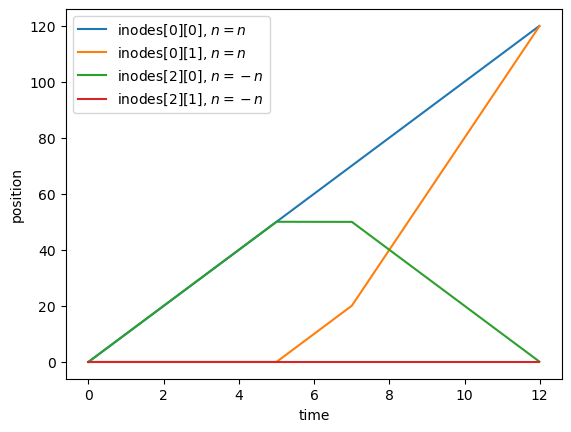

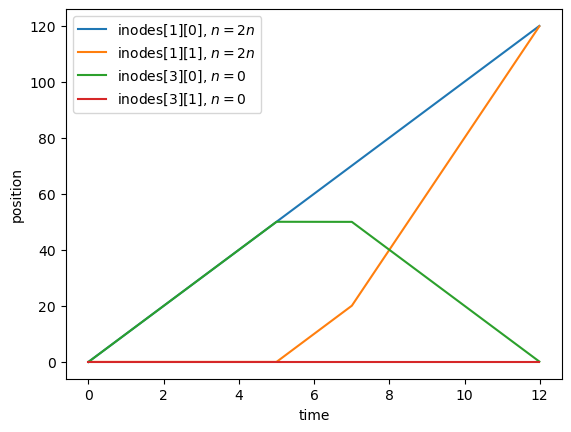

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# Define our substitutions for the analytic calculation
subs = {hbar:1, k:1, m: 1, n: 5, delta: 4*n, omega_m: 8*n, T:5, Tp: 2}

tfinal = float(inodes[0][0].t.evalf(subs=subs))
t = np.linspace(0, tfinal, 1000)

plt.figure()

def plot_pair(i):
    f0 = inodes[i][0].get_trajectory(subs=subs)
    plt.plot(t, f0(t), label=f'inodes[{i}][0], $n={sp.latex(inodes[i][0].n)}$')
    f1 = inodes[i][1].get_trajectory(subs=subs)
    plt.plot(t, f1(t), label=f'inodes[{i}][1], $n={sp.latex(inodes[i][1].n)}$')
    
plot_pair(0)
plot_pair(2)

plt.legend()
plt.ylabel('position')
plt.xlabel('time')
plt.show()

plt.figure()
plot_pair(1)
plot_pair(3)
plt.legend()
plt.ylabel('position')
plt.xlabel('time')
plt.show()

Now that we have identified which nodes correspond to which outputs we are ready to perform the numerical calculation. Lets generate functions that can be used to compute the wavefunction at each output.

Note that we will have these calculations ignore some of the unitary operations: the upper interferometer third and fourth pulses should not be subjected to the unitary operator that describes the multifrequency beamsplitter operation happening on the lower interferometer third and fourth pulses. To do this we define a filter function which only returns true if the node momentum state is equal to one of the states that the beamsplitter is resonant with.

(Note that you could define the `MultiFreqBragg` operator in a different way where it determines all of the states it is resonant with automatically instead of just those specified by `n1` and `n2`--then we wouldn't need to use the filter function.)

In [5]:
# Write a filter function that ensures we don't double-count the effect of the multifrequency beamsplitters
def filterfnc(node, unitary):
    return node.n == unitary.n1 or node.n == unitary.n2

# Get the numeric phase calculation for each output
uuu = inodes[1][0].gen_numeric_wf_func(subs, filter=filterfnc)
udu = inodes[1][1].gen_numeric_wf_func(subs, filter=filterfnc)

uud = inodes[0][0].gen_numeric_wf_func(subs, filter=filterfnc)
udd = inodes[0][1].gen_numeric_wf_func(subs, filter=filterfnc)

duu = inodes[3][0].gen_numeric_wf_func(subs, filter=filterfnc)
ddu = inodes[3][1].gen_numeric_wf_func(subs, filter=filterfnc)

dud = inodes[2][0].gen_numeric_wf_func(subs, filter=filterfnc)
ddd = inodes[2][1].gen_numeric_wf_func(subs, filter=filterfnc)

# Create a function to compute the differential phase
def calc_diff_phase(omega, sigma, v, ratio):
    ph = -(np.angle(-uuu(omega, sigma, v, ratio)/udu(omega, sigma, v, ratio)) - np.angle(-duu(omega, sigma, v, ratio)/ddu(omega, sigma, v, ratio)))
    phh = -(np.angle(uud(omega, sigma, v, ratio)/udd(omega, sigma, v, ratio)) - np.angle(dud(omega, sigma, v, ratio)/ddd(omega, sigma, v, ratio)))
    return (ph+phh)/2

Now we can determine how the phase changes as a function of the input state velocity.

In [6]:
from tqdm import tqdm
from scipy.interpolate import interp1d

# Compute phase value at several velocities
velocities = np.linspace(-3,3,200)
phase_values = np.full_like(velocities, np.nan)
for i in tqdm(range(len(velocities))):
    phase_values[i] = calc_diff_phase(5.05, 0.2, velocities[i]/2, 4.1)

# Interpolate
phase_v_fnc = interp1d(velocities, phase_values)

100%|█████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


We can now plot this against the raw data from Fig. 3b.

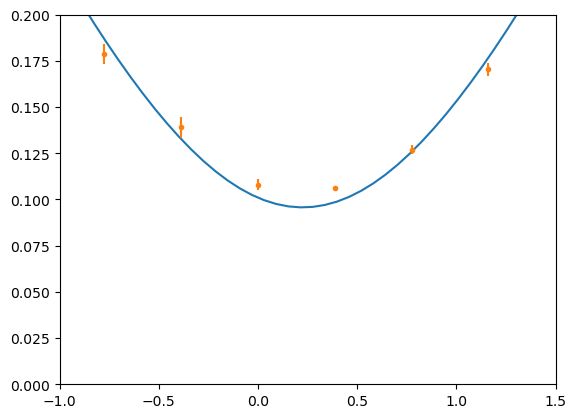

In [7]:
# Set raw data
raw_data_x = np.array([-0.77444,-0.38722,0,0.38722,0.7744,1.16167])
raw_data_y = np.array([0.1785, 0.139,0.108,0.106,0.127,0.1705])
raw_data_err = np.array([0.0054,0.0058,0.00285,0.00155,0.002575,0.0036])

# Plot
vv = np.linspace(-1.5,1.5)
plt.plot(vv,1000*phase_v_fnc(vv-0.225)/16/25/2/np.pi)
plt.errorbar(raw_data_x, raw_data_y, raw_data_err, marker='.', linestyle='none')
plt.xlim([-1,1.5])
plt.ylim([0,0.2])
plt.show()

It doesn't agree because the model in Fig 3b assumes that there is a distribution of velocities entering the interferometer. Lets come up with a form for the velocity distribution based on what we expect after a Raman velocity pulse.

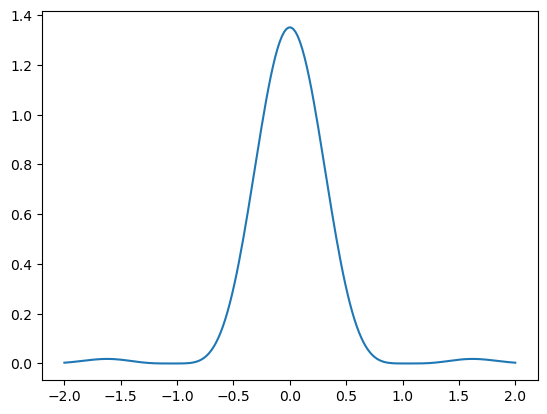

In [8]:
from scipy.integrate import nquad

# We do double velocity selection, so Brian Estey's equation on p.99 of his thesis is relevant
def vel_dist(w, v):
    OmR = np.pi/w
    return (OmR**2/(v**2 + OmR**2)*np.sin((v**2 + OmR**2)**0.5*w/2)**2)**2

# Normalize the velocity distribution
norm_factor = nquad(lambda x: vel_dist(400/77, x), ((-np.inf, np.inf),), opts={'limit':1000})[0]
def vel_dist_norm(v):
    return vel_dist(400/77,v)/norm_factor

# Plot
vv = np.linspace(-2,2,200)
plt.plot(vv, vel_dist_norm(vv))
plt.show()



Now that we have a form for the velocity distribution we can average the phase over it.


C:\Users\jack\miniconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\jack\miniconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


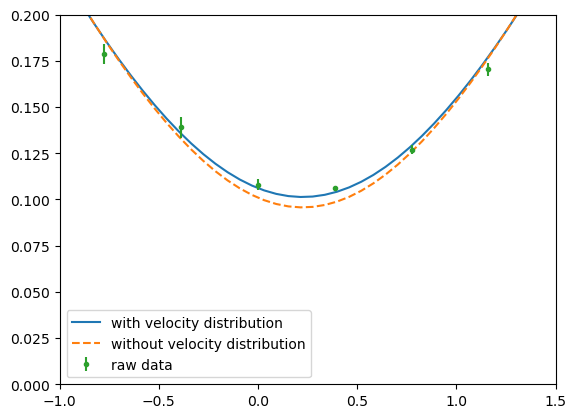

In [9]:
# Define function which computes the phase averaged over the velocity distribution
def weighted_phase_function(v):
    return nquad(lambda x: vel_dist_norm(x)*phase_v_fnc(v+x), ((-1, 1),))[0]

# Compute the phase for a range of different incoming velocities
incoming_velocities = np.linspace(-1.5,1.5)
phases_averaged_over_vdist = np.array([weighted_phase_function(x-0.225) for x in incoming_velocities])

# Plot
plt.plot(incoming_velocities,1000*phases_averaged_over_vdist/16/25/2/np.pi, label='with velocity distribution')
plt.plot(incoming_velocities,1000*phase_v_fnc(incoming_velocities-0.225)/16/25/2/np.pi, '--', label='without velocity distribution')
plt.errorbar(raw_data_x, raw_data_y, raw_data_err, marker='.', linestyle='none', label='raw data')
plt.legend()
plt.xlim([-1,1.5])
plt.ylim([0,0.2])
plt.show()

This is the same as Fig. 3b.